
# YOLOv8 Binary Object Detection and Cropping Pipeline

This notebook includes:

1. Converting YOLO dataset annotations from multi-class to binary.
2. Fine-tuning YOLOv8 for binary detection.
3. Inference pipeline (detection -> cropping -> augmentation -> classification preparation).

Abdulmlik almuhanna

In [1]:

!pip install -q ultralytics roboflow sahi

!pip install -q glob2
import os
from sahi.utils.file import download_from_url
from sahi.utils.ultralytics import download_yolo11n_model
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
import numpy as np
from glob import glob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="TS1niacLXvvWTierCKCT")
project = rf.workspace("insectai").project("my-first-project-fmp4x")
version = project.version(13)
dataset = version.download("yolov11")




loading Roboflow workspace...
loading Roboflow project...


### training the binary detector

In [ ]:
!git clone https://huggingface.co/davsolai/yolo11x-p2-coco


Cloning into 'yolo11x-p2-coco'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (11/11), 3.62 KiB | 1.21 MiB/s, done.


In [ ]:
!cd yolo11x-p2-coco && git fetch origin refs/pr/1:pr/1

From https://huggingface.co/davsolai/yolo11x-p2-coco
 * [new ref]         refs/pr/1  -> pr/1


In [ ]:
!yolo cfg

Printing '/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/default.yaml'

task: detect
mode: train
model: null
data: null
epochs: 100
time: null
patience: 100
batch: 16
imgsz: 640
save: true
save_period: -1
cache: false
device: null
workers: 8
project: null
name: null
exist_ok: false
pretrained: true
optimizer: auto
verbose: true
seed: 0
deterministic: true
single_cls: false
rect: false
cos_lr: false
close_mosaic: 10
resume: false
amp: true
fraction: 1.0
profile: false
freeze: null
multi_scale: false
overlap_mask: true
mask_ratio: 4
dropout: 0.0
val: true
split: val
save_json: false
conf: null
iou: 0.7
max_det: 300
half: false
dnn: false
plots: true
source: null
vid_stride: 1
stream_buffer: false
visualize: false
augment: false
agnostic_nms: false
classes: null
retina_masks: false
embed: null
show: false
save_frames: false
save_txt: false
save_conf: false
save_crop: false
show_labels: true
show_conf: true
show_boxes: true
line_width: null
format: torchscript
keras: false
optimiz

In [ ]:
import yaml

# Define hyperparameters for the detector model
hyperparams = { # Replace this dynamically if needed
    'epochs': 200,
    'imgsz': 1504,
    'batch': 1,
    'project': 'binary_detector',
    'max_det': 600,
    'single_cls':True,
    'visualize':True,
    'save_crop':True,
    'show_labels':False,
    'warmup_epochs':20.0,
}

# Save the hyperparameters to a YAML file
with open("cgs.yaml", "w") as file:
  yaml.dump(hyperparams, file)
print("Hyperparameters saved to 'cgs.yaml'.")

Hyperparameters saved to 'cgs.yaml'.


In [ ]:

# Fine-tune YOLOv8 on binary dataset
model = YOLO("/content/model (1) (1).pt")
#model = YOLO('/hpc/home/ama191/Our_Yolo_Solution/binary_detector/train31/weights/best.pt')  # You can change modl size
#model = YOLO("yolo11x-pose")

In [ ]:
model.train(data=f"{dataset.location}/data.yaml",cfg="./cgs.yaml")


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=./cgs.yaml, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/insects_noclasses-7/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1504, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=600, mixup=0.0, mode=train, model=/content/model (1) (1).pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

100%|██████████| 755k/755k [00:00<00:00, 108MB/s]

Overriding class names with single class.
Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              


  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  8                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  9                  -1  1   1476864  ultralytics.nn.modules.block.SPPF            [768, 768, 5]                 
 10                  -1  2   3264768  ultralytics.nn.modules.block.C2PSA           [768, 768, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   5612544  ultralytics.nn.modules.block.C3k2            [1536, 768, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

100%|██████████| 5.35M/5.35M [00:00<00:00, 408MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1635.0±1361.4 MB/s, size: 221.0 KB)


train: Scanning /content/insects_noclasses-7/train/labels... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 810.17it/s]

train: New cache created: /content/insects_noclasses-7/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 589.7±54.2 MB/s, size: 277.6 KB)


val: Scanning /content/insects_noclasses-7/valid/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 255.01it/s]

val: New cache created: /content/insects_noclasses-7/valid/labels.cache


Plotting labels to binary_detector/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 206 weight(decay=0.0), 215 weight(decay=0.0005), 214 bias(decay=0.0)
Image sizes 1504 train, 1504 val
Using 2 dataloader workers
Logging results to binary_detector/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/105 [00:00<?, ?it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      14.4G      3.257      4.141      2.238        625       1504:   4%|▍         | 4/105 [00:40<10:01,  5.96s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      14.4G      3.188      4.203      2.435         61       1504:   8%|▊         | 8/105 [01:13<08:08,  5.04s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      14.4G      3.091      4.434      2.461        309       1504:  13%|█▎        | 14/105 [01:44<03:57,  2.61s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      14.5G      2.412      3.021      1.896         53       1504:  61%|██████    | 64/105 [02:53<00:30,  1.32it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      14.5G      2.373      2.902      1.864        190       1504:  67%|██████▋   | 70/105 [03:23<01:12,  2.06s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      14.5G      2.372      2.863      1.858         54       1504:  70%|██████▉   | 73/105 [03:53<02:48,  5.28s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


In [ ]:
model.val(save=True)

Ultralytics 8.3.40 🚀 Python-3.11.7 torch-2.7.0+cu126 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48509MiB)
YOLO11x-p2 summary (fused): 571 layers, 57,739,092 parameters, 0 gradients, 242.6 GFLOPs


val: Scanning /hpc/home/mvr18/insects_noclasses-7/valid/labels.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


                   all          4       2444      0.886      0.722      0.803       0.39
Speed: 0.5ms preprocess, 165.0ms inference, 0.0ms loss, 10.7ms postprocess per image
Results saved to binary_detector/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f7bf1e47910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### SAHI experiment

In [ ]:
# i have the model pre trained
model_path="binary_detector/train/weights/best.pt"
model = YOLO("binary_detector/train/weights/best.pt")
#model.predict(source="/content/insects_noclasses-7/test/images/test_img_cropped.JPG",save=True,iou=0.5)

Standard Predection without SAHI

In [ ]:
from sahi import AutoDetectionModel

detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.1,
    device="cuda:0",
    )

In [ ]:
from sahi.predict import get_prediction

# With an image path
result = get_prediction("insects_noclasses-7/valid/images/W5_20220509_3_ST220183_B_JPG.rf.0764a013ea81011bf16b25641556f244.jpg", detection_model)


In [ ]:
len(result.object_prediction_list)


300

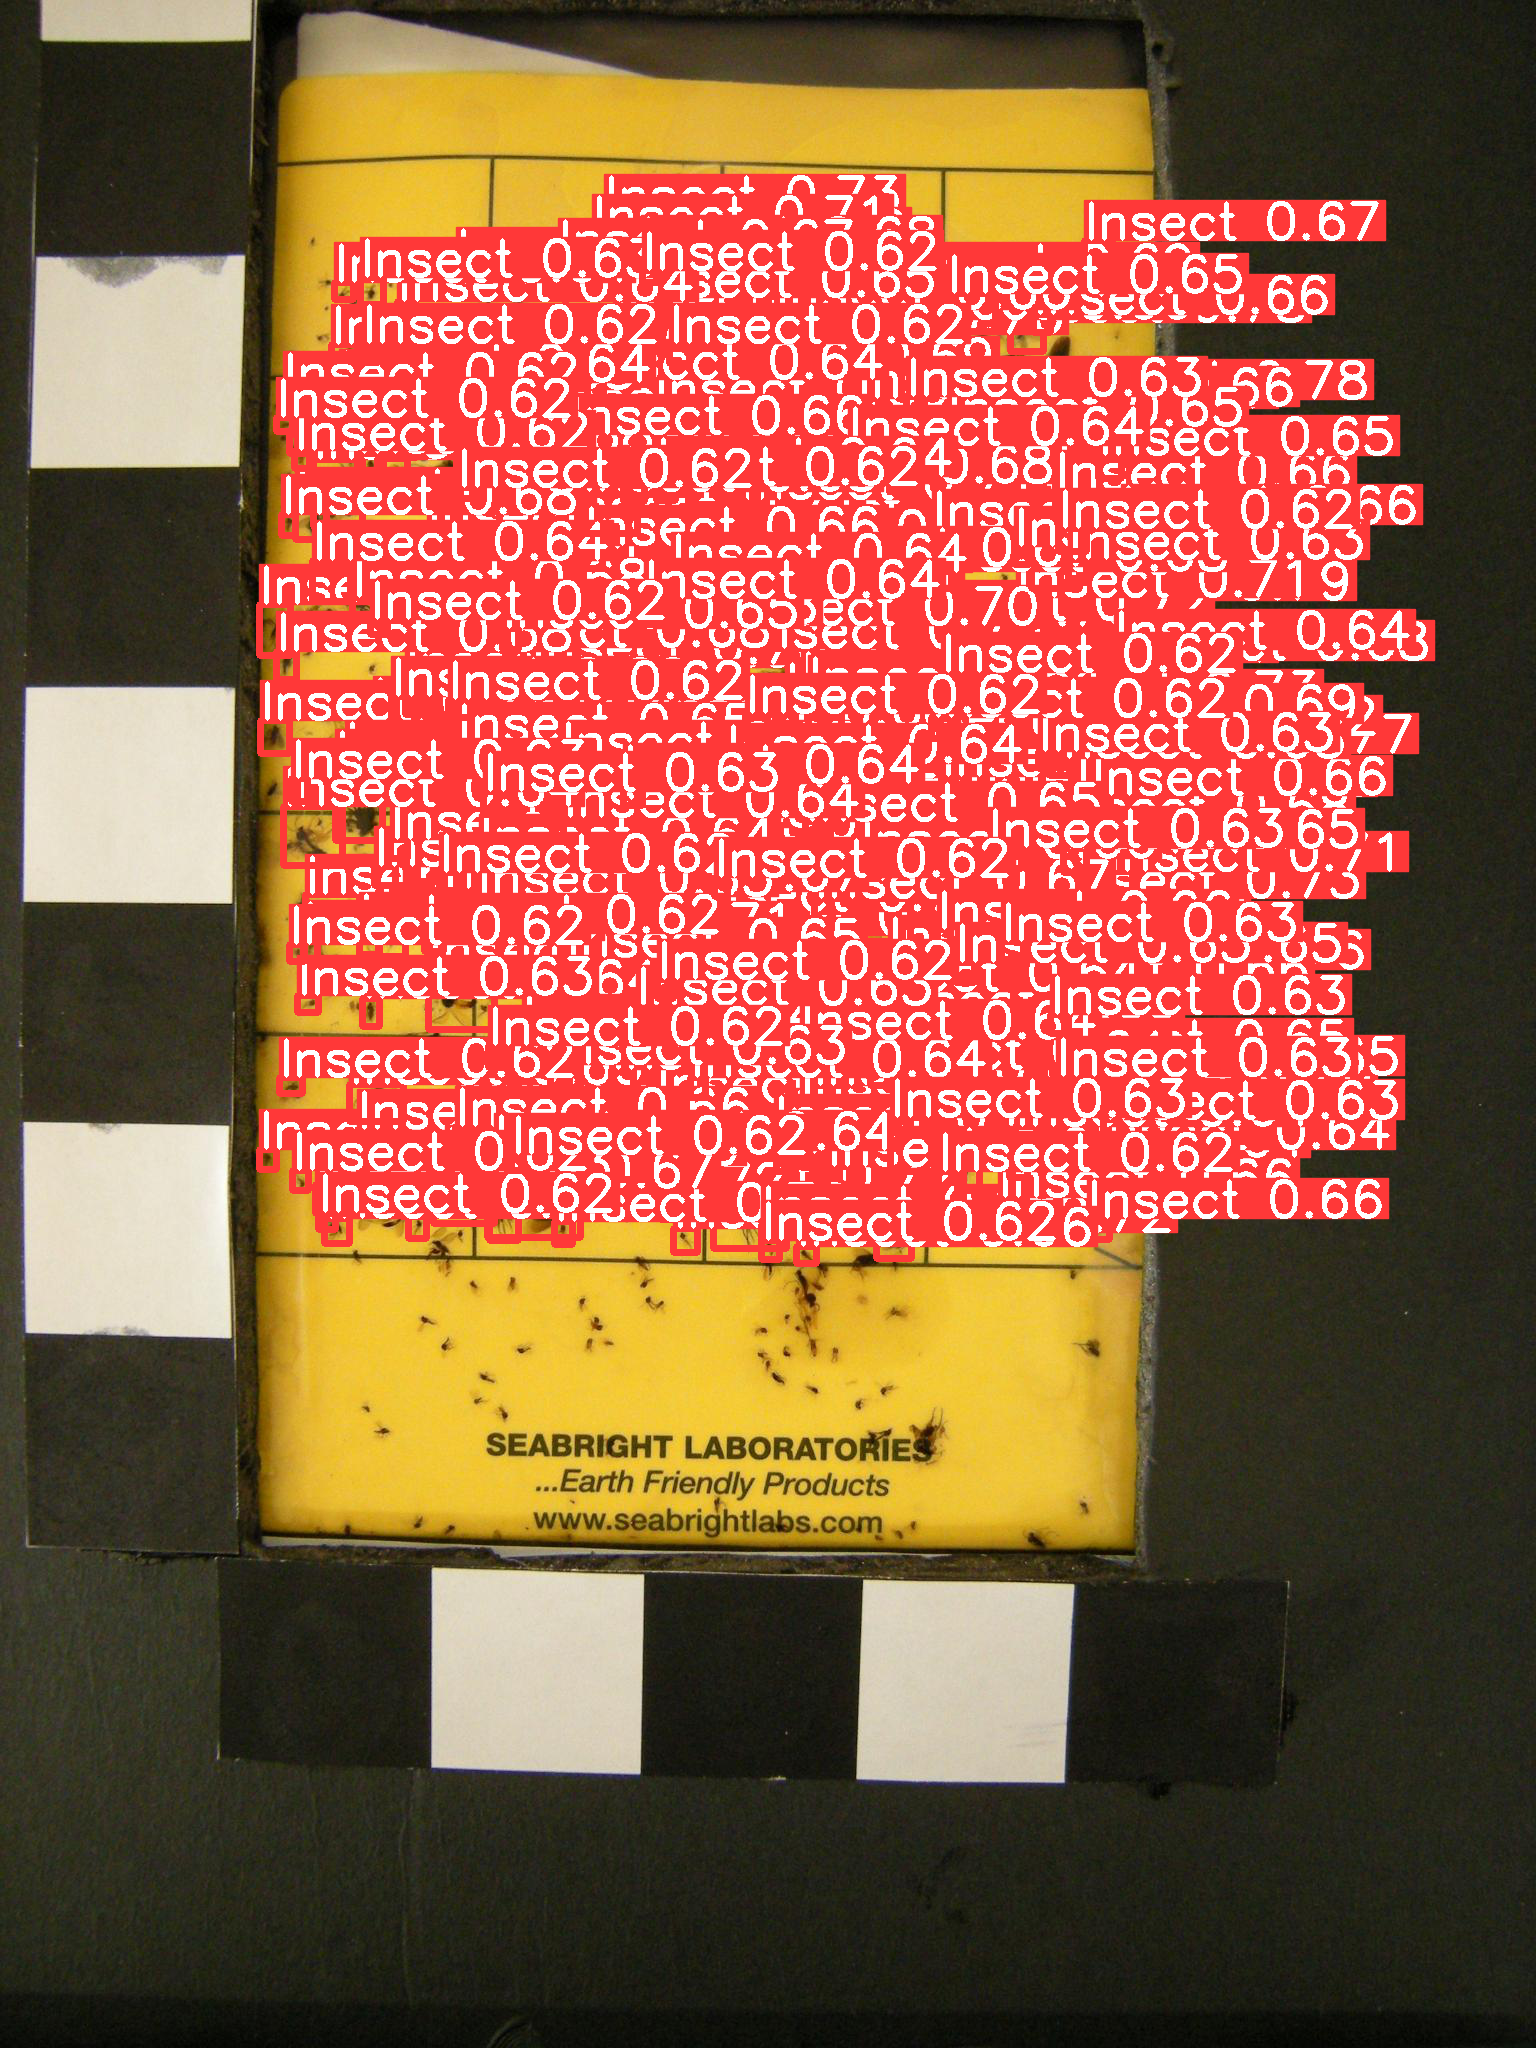

In [ ]:

from IPython.display import Image
result.export_visuals(export_dir="sihi_data/")
result.object_prediction_list
Image("sihi_data/prediction_visual.png")


In [ ]:
from sahi.predict import get_sliced_prediction

result = get_sliced_prediction(
    "insects_noclasses-7/valid/images/W5_20220509_5_ST220185_A_JPG.rf.250d5808c78141a5bbe0067478bc12e6.jpg",
    detection_model,
    slice_height=1024,
    slice_width=1024,
    overlap_height_ratio=0.5,
    overlap_width_ratio=0.5,
)


Performing prediction on 6 slices.


In [ ]:
len(result.object_prediction_list)


405

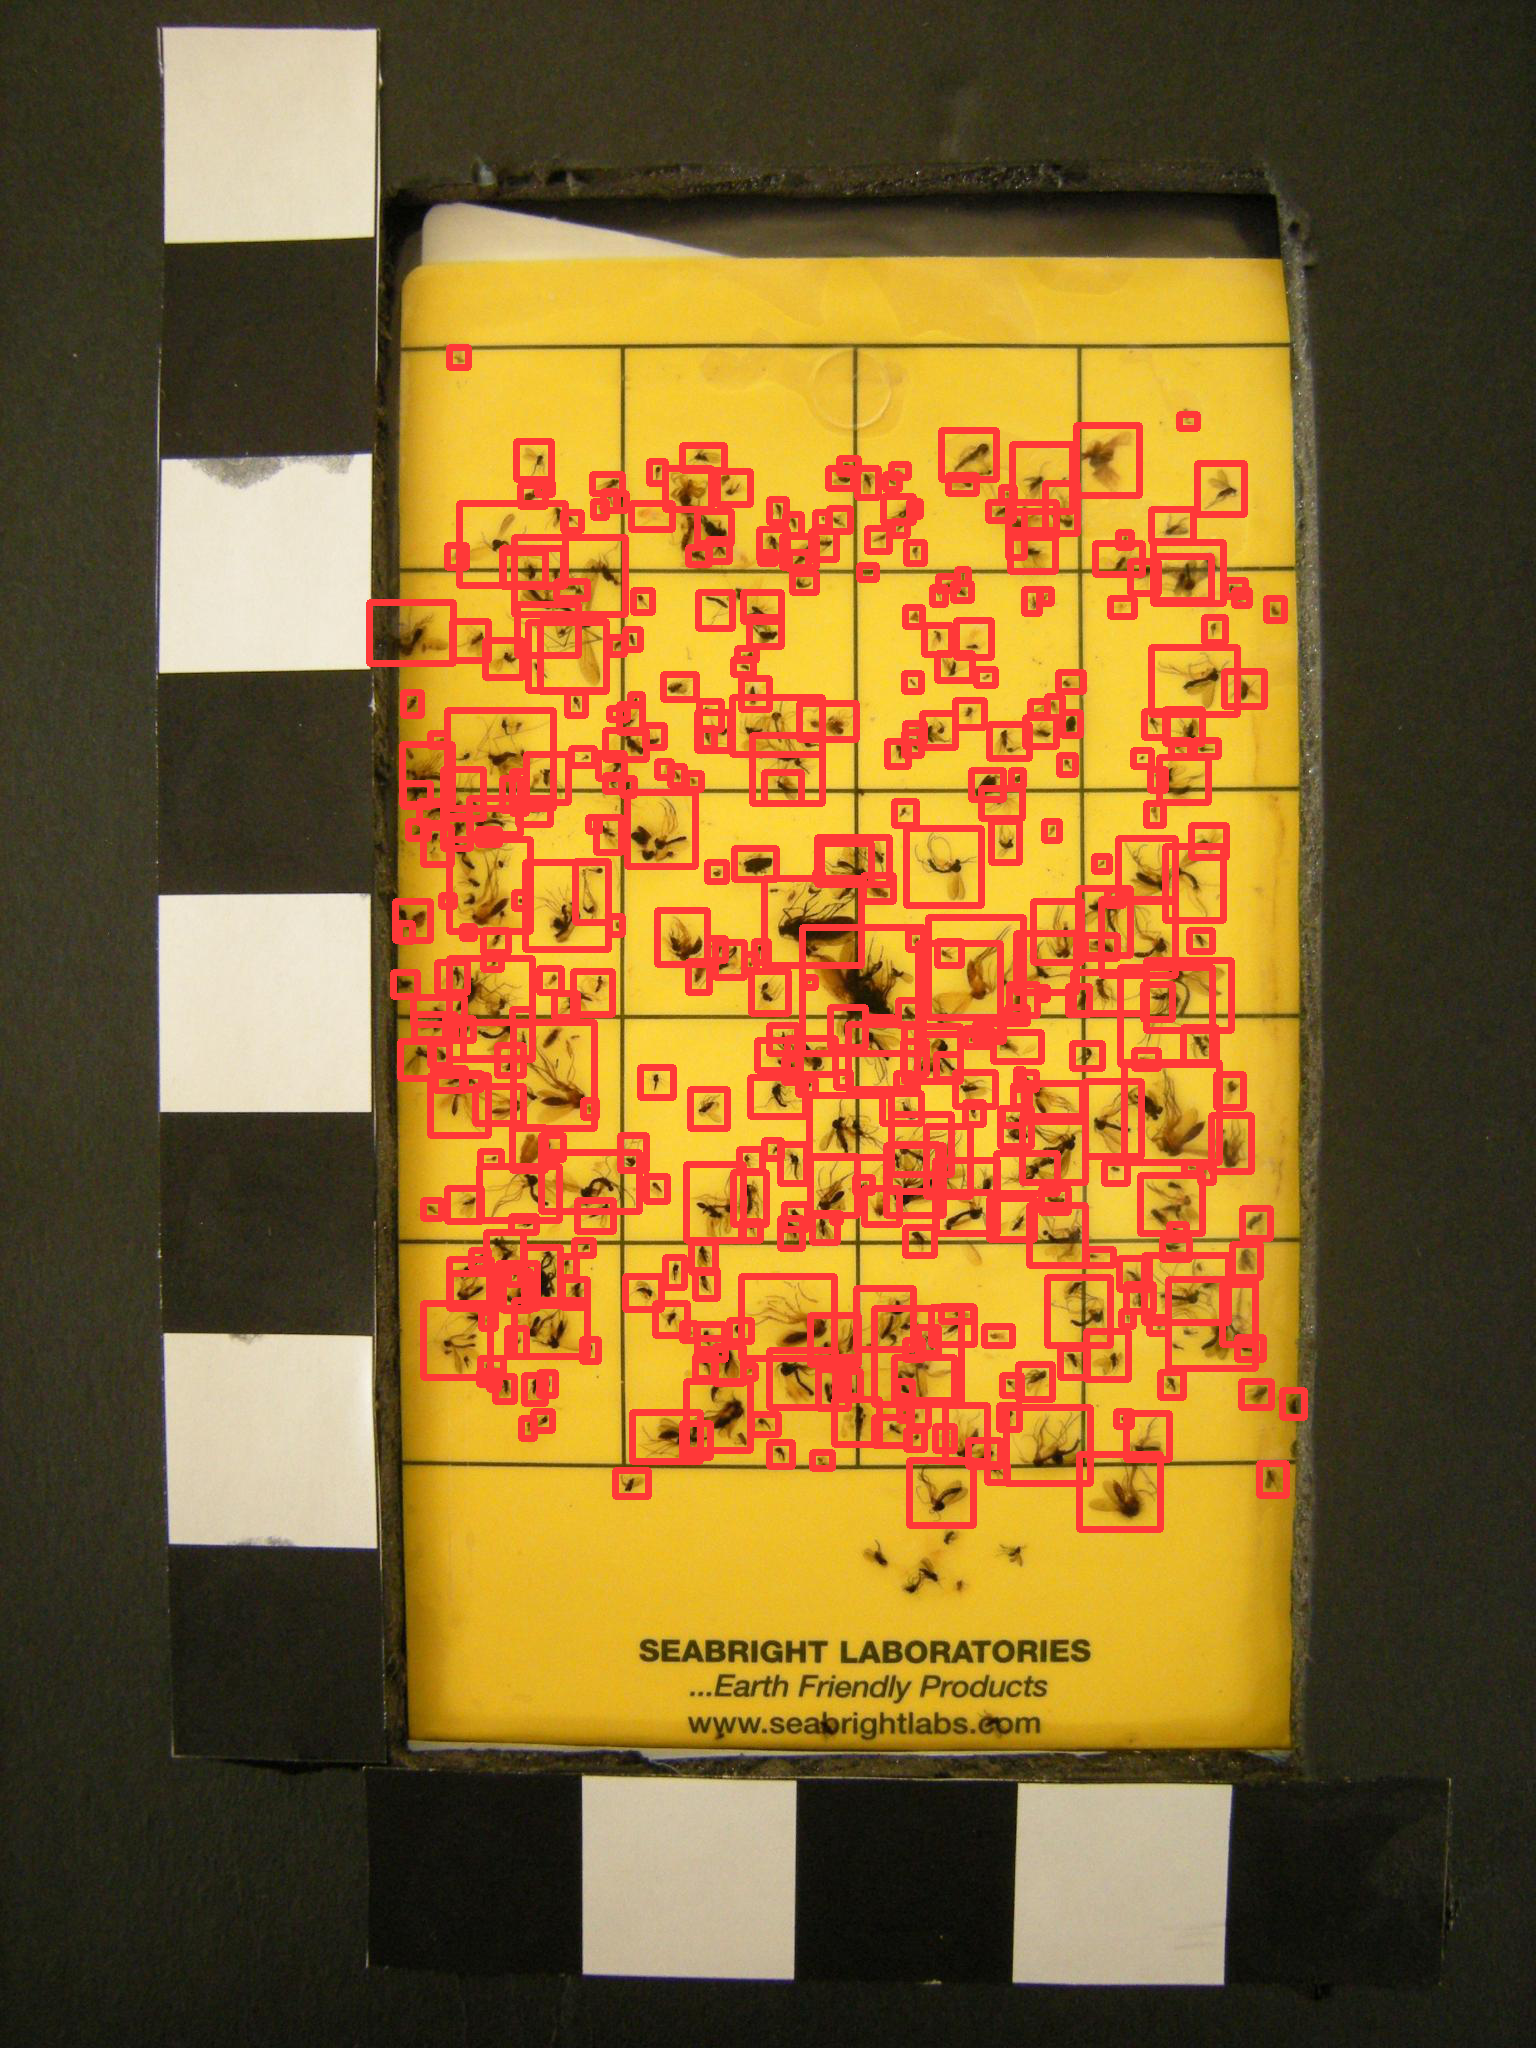

In [ ]:
from IPython.display import Image
result.export_visuals(export_dir="real_sihi/",hide_labels=True)
result.object_prediction_list
Image("real_sihi/prediction_visual.png")


Performing prediction on 1 slices.
0


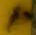

In [ ]:
from sahi.predict import get_sliced_prediction

result = get_sliced_prediction(
    "./W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop144.jpg",
    detection_model,
    slice_height=100,
    slice_width=100,
    overlap_height_ratio=0.5,
    overlap_width_ratio=0.5,
)
print(len(result.object_prediction_list))
from IPython.display import Image
result.export_visuals(export_dir="real_sihi/",hide_labels=True)
result.object_prediction_list
Image("real_sihi/prediction_visual.png")

0


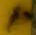

In [ ]:
from sahi.predict import get_prediction

# With an image path
result = get_prediction("./W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop144.jpg", detection_model)
print(len(result.object_prediction_list))
from IPython.display import Image
result.export_visuals(export_dir="real_sihi/",hide_labels=True)
result.object_prediction_list
Image("real_sihi/prediction_visual.png")

In [ ]:
%matplotlib inline

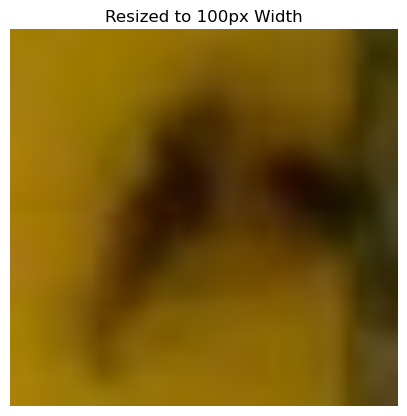

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('./W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop144.jpg')  # Replace with your actual path

# Resize to width = 100px while maintaining aspect ratio
height, width = image.shape[:2]
new_width = 640
scale_ratio = new_width / float(width)
new_height = int(height * scale_ratio)
resized_image = cv2.resize(image, (new_width, new_height))

# Convert BGR (OpenCV default) to RGB for display
resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

# Plot using matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(resized_rgb)
plt.title("Resized to 100px Width")
plt.axis('off')
plt.show()

In [ ]:
cv2.imwrite("resized_input.jpg", resized_image)

True

0


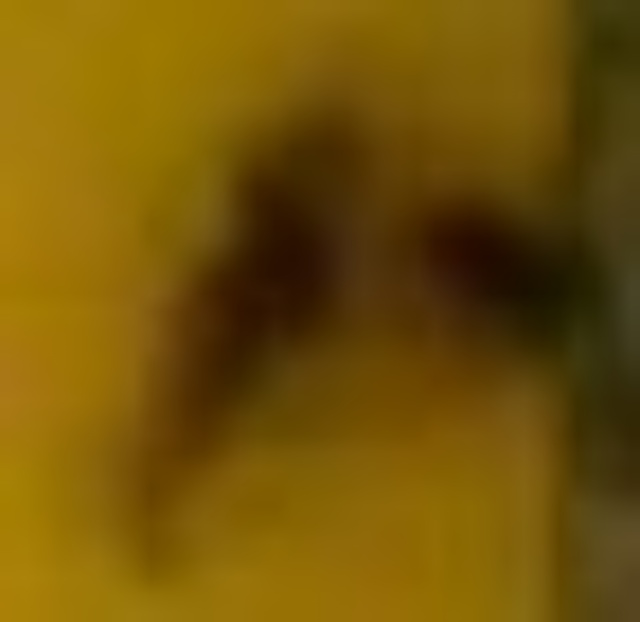

In [ ]:
from sahi.predict import get_prediction

# With an image path
result = get_prediction("resized_input.jpg", detection_model)
print(len(result.object_prediction_list))
from IPython.display import Image
result.export_visuals(export_dir="real_sihi/",hide_labels=True)
result.object_prediction_list
Image("real_sihi/prediction_visual.png")

Performing prediction on 20 slices.
0


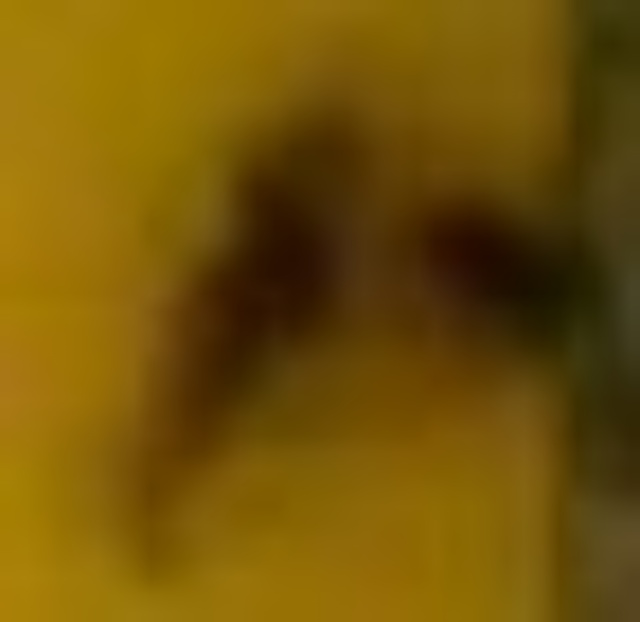

In [ ]:
from sahi.predict import get_sliced_prediction

result = get_sliced_prediction(
    "resized_input.jpg",
    detection_model,
    slice_height=250,
    slice_width=250,
    overlap_height_ratio=0.5,
    overlap_width_ratio=0.5,
)
print(len(result.object_prediction_list))
from IPython.display import Image
result.export_visuals(export_dir="real_sihi/",hide_labels=True)
result.object_prediction_list
Image("real_sihi/prediction_visual.png")

In [ ]:
from ultralytics import YOLO
model = YOLO('./best_classifer_finetune_num2.pt')
results = model.predict('W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop144.jpg', save_txt=True)
results[0].save()


image 1/1 /hpc/home/mvr18/W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop144.jpg: 224x224 1 0.54, 0 0.38, 3 0.07, 5 0.01, 2 0.00, 2.4ms
Speed: 2.4ms preprocess, 2.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Results saved to runs/classify/predict
1 label saved to runs/classify/predict/labels


'results_W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop144.jpg'

### Cropping part

In [ ]:

def crop_predictions(PPimage_path, model, conf_thresh=0.01):
    results = model.predict(image_path, conf=conf_thresh,max_det=800)[0]
    img = cv2.imread(image_path)
    crops = []
    for box in results.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        crop = img[y1:y2, x1:x2]
        crops.append(crop)
    return crops


In [ ]:

# Load your trained binary detector
binary_detector =model
from glob import glob
import glob2

"""image_example = glob("W5_20220509_2_ST220182_A_JPG.rf.5d17c8a1b9b500761e1d6006c44d8dc9.jpg")
print(image_example)
cropped_images = crop_predictions(image_example[0], binary_detector)
"""
# Visualize crops
import matplotlib.pyplot as plt
import os
"""for i, crop in enumerate(cropped_images[:5]):  # visualize first 5 crops
    plt.figure()
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title(f"Cropped Image {i+1}")
    plt.axis('off')
    plt.show()
"""
image_paths = glob("./insects_noclasses-7/test/images/*.jpg")  # Adjust as needed
output_dir="./our_cropped"
os.makedirs(output_dir, exist_ok=True)
# Loop through images, crop, and save
for image_path in image_paths:
    crops = crop_predictions(image_path, binary_detector)
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    for idx, crop in enumerate(crops):
        save_path = os.path.join(output_dir, f"{base_name}_crop{idx}.jpg")
        cv2.imwrite(save_path, crop)

print(f"Saved all cropped images to: {output_dir}")


image 1/1 /hpc/home/mvr18/insects_noclasses-7/test/images/W5_20230821_3_ST230743_B_JPG.rf.78954bd80d535b8aed00173c5773ed72.jpg: 1152x1504 54 Insects, 32.9ms
Speed: 18.5ms preprocess, 32.9ms inference, 2.6ms postprocess per image at shape (1, 3, 1152, 1504)

image 1/1 /hpc/home/mvr18/insects_noclasses-7/test/images/W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4.jpg: 1504x1152 318 Insects, 30.0ms
Speed: 12.6ms preprocess, 30.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1504, 1152)
Saved all cropped images to: ./our_cropped



## Next Steps:

- Apply augmentations on training cropped images. (per class)
- Feed cropped images into our classification model to fine tune it .
(Add your augmentation and classification inference code here.)

- after fine tuning our classification model we can run a total inference including both models



### Load Roboflow Dataset
Replace with your Roboflow API Key and Dataset Information.

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="TS1niacLXvvWTierCKCT")
project = rf.workspace("insectai").project("my-first-project-fmp4x")
dataset = project.version(12).download("yolov8")

print(f"Dataset location: {dataset.location}")






loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-12 in yolov8:: 100%|██████████| 100/100 [00:00<00:00, 192.67it/s]


Dataset location: /hpc/home/ama191/My-First-Project-12


### Imports and Paths

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from collections import Counter
import random

label_dir = os.path.join(dataset.location, "train", "labels")
image_dir = os.path.join(dataset.location, "train", "images")
cropped_output_dir = "cropped_dataset"
os.makedirs(cropped_output_dir, exist_ok=True)



### YOLO Conversion Functions

In [ ]:

def yolo_to_xyxy(bbox, img_w, img_h):
    x_c, y_c, w, h = bbox
    x1 = int((x_c - w / 2) * img_w)
    y1 = int((y_c - h / 2) * img_h)
    x2 = int((x_c + w / 2) * img_w)
    y2 = int((y_c + h / 2) * img_h)
    return x1, y1, x2, y2


### Image Augmentation

In [ ]:

def apply_augmentations(crop):
    angle = random.choice([0, 90, 180, 270])
    angle=angle + (np.random.random_integers(0,15))
    if angle:
        crop = np.rot90(crop, k=angle // 90)

    crop = cv2.GaussianBlur(crop, (5, 5), 0)
    noise = np.random.normal(0, 0.1, crop.shape).astype(np.uint8)
    crop = cv2.add(crop, noise)

    return crop


# Crop and Augment

In [ ]:

rare_classes = [0, 2,4]  # Modify as needed
augment_factor = 3

class_counter = Counter()

for label_file in tqdm(glob(f"{label_dir}/*.txt")):
    image_file = label_file.replace('/labels/', '/images/').replace('.txt', '.jpg')
    img = cv2.imread(image_file)
    h, w = img.shape[:2]

    with open(label_file, "r") as f:
        lines = f.readlines()

        for idx, line in enumerate(lines):
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            x1, y1, x2, y2 = yolo_to_xyxy(bbox, w, h)

            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            class_folder = os.path.join(cropped_output_dir, str(class_id))
            os.makedirs(class_folder, exist_ok=True)

            filename = os.path.basename(image_file).replace('.jpg', f'_{idx}.jpg')
            cv2.imwrite(os.path.join(class_folder, filename), crop)
            class_counter[class_id] += 1

            if class_id in rare_classes:
                for aug_idx in range(augment_factor):
                    aug_crop = apply_augmentations(crop)
                    aug_filename = os.path.basename(image_file).replace('.jpg', f'_{idx}_aug{aug_idx}.jpg')
                    cv2.imwrite(os.path.join(class_folder, aug_filename), aug_crop)
                    class_counter[class_id] += 1

print("Class distribution after cropping and augmentation:", class_counter)


100%|██████████| 36/36 [00:40<00:00,  1.12s/it]

Class distribution after cropping and augmentation: Counter({1: 7631, 3: 667, 5: 287, 4: 132, 0: 48, 2: 12})


# Dataset Preparation for YOLO Classification

In [ ]:
!pip install sklearn
from sklearn.model_selection import train_test_split
import shutil

classification_dir = "classification_dataset"
os.makedirs(classification_dir, exist_ok=True)

for class_id in os.listdir(cropped_output_dir):
    class_path = os.path.join(cropped_output_dir, class_id)
    images = glob(os.path.join(class_path, '*.jpg'))

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for phase, img_paths in [('train', train_imgs), ('val', val_imgs)]:
        phase_class_dir = os.path.join(classification_dir, phase, class_id)
        os.makedirs(phase_class_dir, exist_ok=True)

        for img_path in img_paths:
            shutil.copy(img_path, phase_class_dir)

print("Dataset structured for YOLO classification at:", classification_dir)


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-vovrrbou/sklearn_660f25dc76c845e19dd404d51ca3bdee/setup.py'"'"'; __file__='"'"'/tmp/pip-install-vovrrbou/sklearn_660f25dc76c845e19dd404d51ca3bdee/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-wih17095
       cwd: /tmp/pip-install-vovrrbou/sklearn_660f25dc76c845e19dd404d51ca3bdee/
  Complete output (15 lines):
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error 

# Train YOLO Classification Model

In [ ]:

!yolo task=classify mode=train model=yolov8s-cls.pt data={classification_dir} epochs=10 imgsz=224



100%|██████████████████████████████████████| 12.3M/12.3M [00:00<00:00, 72.7MB/s]
Ultralytics 8.3.146 🚀 Python-3.9.19 torch-2.7.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=classification_dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=au

In [ ]:

!yolo task=classify save_txt=True mode=predict model="/content/best_classifer_finetune_num2.pt" source={"/content/our_cropped2"}  imgsz=224



Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,082,886 parameters, 0 gradients, 12.5 GFLOPs

image 1/620 /content/our_cropped2/W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop0.jpg: 224x224 0 0.38, 1 0.34, 3 0.22, 4 0.04, 5 0.02, 4.4ms
image 2/620 /content/our_cropped2/W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop1.jpg: 224x224 1 0.63, 0 0.35, 3 0.02, 5 0.00, 2 0.00, 3.6ms
image 3/620 /content/our_cropped2/W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop10.jpg: 224x224 1 0.56, 0 0.40, 3 0.04, 5 0.01, 2 0.00, 3.3ms
image 4/620 /content/our_cropped2/W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop100.jpg: 224x224 1 0.52, 0 0.35, 3 0.13, 5 0.00, 2 0.00, 3.2ms
image 5/620 /content/our_cropped2/W5_20220509_4_ST220184_A_JPG.rf.e4aa48e345f56ab1a719a223e7e08da4_crop101.jpg: 224x224 0 0.36, 1 0.36, 3 0.28, 5 0.00, 4 0.0

In [ ]:
!pip install glob

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [ ]:
import chardet

with open("/hpc/home/ama191/runs/classify/predict4/labels/W5_20220509_2_ST220182_A_JPG.rf.5d17c8a1b9b500761e1d6006c44d8dc9_crop0.txt", "rb") as f:
    raw = f.read()
    result = chardet.detect(raw)
    encoding = result['encoding']
    print(encoding)




ascii


In [ ]:
import os
from collections import Counter

def count_top_predicted_classes(folder_path):
    """
    Reads all prediction .txt files in the folder and counts how often
    each class is the top (highest confidence) prediction in a file.

    Returns:
        Counter: A dictionary of class_id → count
    """
    top_class_counter = Counter()

    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            file_path = os.path.join(folder_path, file)
            top_conf = -1
            top_class = None

            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        conf = float(parts[0])
                        cls = int(parts[1])
                        if conf > top_conf:
                            top_conf = conf
                            top_class = cls

            if top_class is not None:
                top_class_counter[top_class] += 1

    return top_class_counter
count_top_predicted_classes("/content/runs/classify/predict/labels")

Counter({0: 78, 1: 531, 5: 7, 3: 4})